In [79]:
%matplotlib inline

import sys
sys.path.append("../")

import numpy as np
import fbprophet
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose


from src import dataset


In [58]:
excel_file = "20160921-analysisofestimatedarrivals.xlsx"
df = dataset.load_excel(excel_file)

In [59]:
df.head()

,Arrivals to Italy
Date,
2015-10-01,343
2015-10-02,0
2015-10-03,128
2015-10-04,62
2015-10-05,0


In [60]:
df.tail()

,Arrivals to Italy
Date,
2016-09-17,317
2016-09-18,0
2016-09-19,47
2016-09-20,0
2016-09-21,0


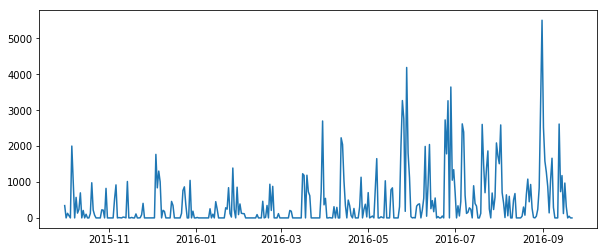

In [61]:
plt.figure(figsize=(10,4))
plt.plot(df.index, df["Arrivals to Italy"])
plt.show()

In [62]:
rollmean  = df.rolling(window=30).mean()
rollstd  = df.rolling(window=30).std()

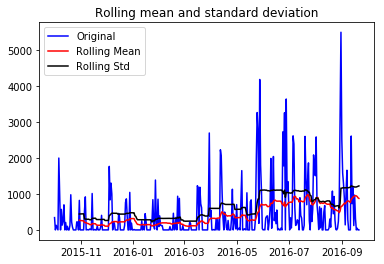

In [63]:
orig = plt.plot(df, color="blue", label="Original")
mean = plt.plot(rollmean, color="red", label="Rolling Mean")
std = plt.plot(rollstd, color="black", label="Rolling Std")
plt.legend(loc="best")
plt.title("Rolling mean and standard deviation")
plt.show(block=False)

In [84]:
# Resample by weeks
w_df = df.resample("W").sum()
w_df = w_df.reset_index().rename(columns={'Date': 'ds', 'Arrivals to Italy': 'y'})
w_df = w_df.set_index("ds")


In [85]:
w_df['y'] = w_df['y'].replace(to_replace=0, method='ffill')
w_df.head()

,y
ds,
2015-10-04,533
2015-10-11,3954
2015-10-18,1007
2015-10-25,1399
2015-11-01,1265


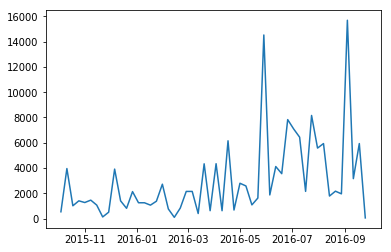

In [67]:
plt.plot(w_df.index, w_df["y"])
plt.show()

In [68]:
w_rollmean = w_df.rolling(window=7).mean()
w_rollstd = w_df.rolling(window=7).std()

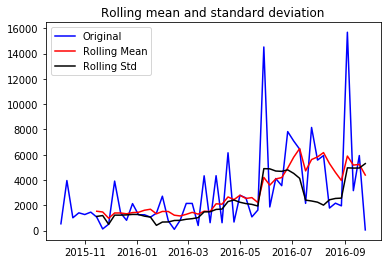

In [69]:
orig = plt.plot(w_df, color="blue", label="Original")
mean = plt.plot(w_rollmean, color="red", label="Rolling Mean")
std = plt.plot(w_rollstd, color="black", label="Rolling Std")
plt.legend(loc="best")
plt.title("Rolling mean and standard deviation")
plt.show(block=False)

In [86]:
w_df.head()

,y
ds,
2015-10-04,533
2015-10-11,3954
2015-10-18,1007
2015-10-25,1399
2015-11-01,1265


In [102]:
# w_df = w_df.reset_index()
logged = np.log(w_df)
print(w_df.shape)

decomposistion = seasonal_decompose(logged, model="additive")
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

AttributeError: 'int' object has no attribute 'log'

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


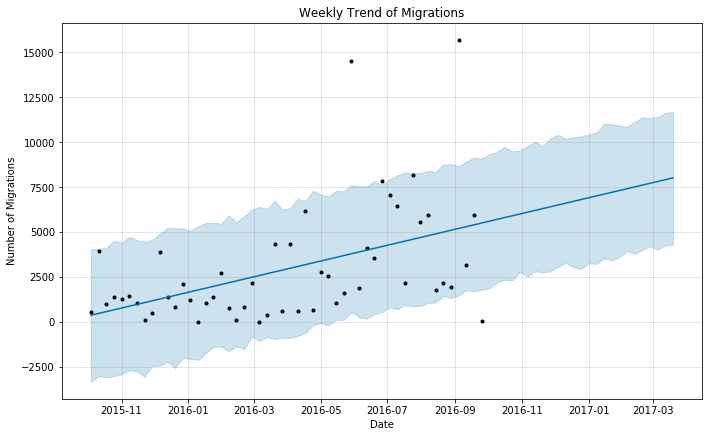

In [54]:
ph_model = fbprophet.Prophet(changepoint_prior_scale=0.14)
ph_model.fit(w_df)
ph_forecast = ph_model.make_future_dataframe(periods=25, freq='W')
ph_forecast = ph_model.predict(ph_forecast)

ph_model.plot(ph_forecast, xlabel = 'Date', ylabel = 'Number of Migrations')
plt.title('Weekly Trend of Migrations')
plt.show()